In [48]:
import pandas as pd

hit_file = "../ml/processed_events/normalized_features_z_3.parquet"
train_data = pd.read_parquet(hit_file)

In [ ]:
import sklearn as sk
from sklearn.model_selection import train_test_split

input_columns = [
            "primary_kinetic_energy",
            "sin_azimuth", "cos_azimuth", "sin_zenith", "cos_zenith"
        ]
output_columns = [
            "kinetic_energy", 
            "distance",
            "X_transformed", "Y_transformed", "Z_transformed",
        ]
batch_identifier = "event_id"

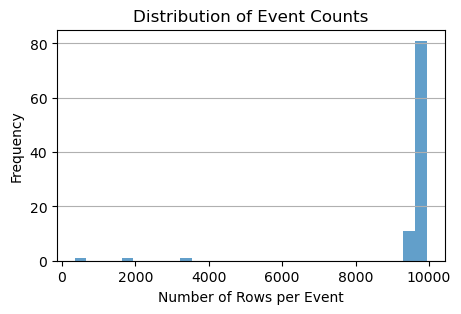

In [50]:
import matplotlib.pyplot as plt

# count number of rows per event and plot distribution
event_counts = train_data[batch_identifier].value_counts().sort_index()
plt.figure(figsize=(5, 3))
plt.hist(event_counts, bins=30, alpha=0.7)
plt.title("Distribution of Event Counts")
plt.xlabel("Number of Rows per Event")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

In [51]:
# print average variation in input columns for each event
for col in input_columns:
    event_variation = train_data.groupby(batch_identifier)[col].std()
    print(f"Average variation in {col} per event:\n", event_variation.mean())

Average variation in primary_kinetic_energy per event:
 0.0
Average variation in sin_azimuth per event:
 0.0
Average variation in cos_azimuth per event:
 0.0
Average variation in sin_zenith per event:
 0.0
Average variation in cos_zenith per event:
 0.0


In [52]:
# for each event keep the input features and calcuate mean and std of the outptu features
# save mean and std in separate columns using _ suffixes
event_stats = train_data.groupby(batch_identifier).agg(
    {
        **{col : 'first' for col in input_columns},
        **{col: ['mean', 'std'] for col in output_columns}
    }
).reset_index()

event_stats.columns = [f"{col}_{stat}" if stat in ['mean', 'std'] else col for col, stat in event_stats.columns]

In [53]:
# update output feature names
output_columns = [f"{col}_mean" for col in output_columns] + [f"{col}_std" for col in output_columns]

In [54]:
event_stats.head()

,event_id,primary_kinetic_energy,sin_azimuth,cos_azimuth,sin_zenith,cos_zenith,kinetic_energy_mean,kinetic_energy_std,distance_mean,distance_std,X_transformed_mean,X_transformed_std,Y_transformed_mean,Y_transformed_std,Z_transformed_mean,Z_transformed_std
0,33619162.0,-1.490952,0.105454,0.994424,0.046285,0.998928,-0.251542,0.746769,-0.145662,0.962048,0.646231,0.751918,0.474124,1.188510,-0.147211,0.961667
1,33619823.0,-0.579293,0.085189,0.996365,0.041124,0.999154,-0.225853,0.802012,-0.134337,1.001135,0.422394,0.649640,0.256833,0.831571,-0.135153,1.000968
2,33619872.0,0.516080,0.021693,0.999765,0.001436,0.999999,0.071062,1.004456,0.172124,0.873949,-1.422239,0.233482,-0.277953,0.557183,0.174342,0.874513
3,33619891.0,-0.467041,0.062685,0.998033,0.007695,0.999970,-0.214330,0.801039,-0.161847,1.068925,-1.132140,0.358457,-0.209237,0.858238,-0.159947,1.069582
4,33619916.0,-0.611274,0.075489,0.997147,0.044536,0.999008,-0.132218,0.844476,0.183308,0.814891,0.782424,0.632485,0.284270,1.065158,0.181882,0.814624


In [55]:
print(f"Event stats columns: {event_stats.columns}")
print(f"Input columns: {input_columns}")
print(f"Output columns: {output_columns}")

Event stats columns: Index(['event_id', 'primary_kinetic_energy', 'sin_azimuth', 'cos_azimuth',
       'sin_zenith', 'cos_zenith', 'kinetic_energy_mean', 'kinetic_energy_std',
       'distance_mean', 'distance_std', 'X_transformed_mean',
       'X_transformed_std', 'Y_transformed_mean', 'Y_transformed_std',
       'Z_transformed_mean', 'Z_transformed_std'],
      dtype='object')
Input columns: ['primary_kinetic_energy', 'sin_azimuth', 'cos_azimuth', 'sin_zenith', 'cos_zenith']
Output columns: ['kinetic_energy_mean', 'distance_mean', 'X_transformed_mean', 'Y_transformed_mean', 'Z_transformed_mean', 'kinetic_energy_std', 'distance_std', 'X_transformed_std', 'Y_transformed_std', 'Z_transformed_std']


In [56]:
# split inputs and outputs 
X = event_stats[input_columns]
y = event_stats[output_columns]

# split into training and validation sets using sklearn
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234)

print(f"Training set size: {X_train.shape[0]} events")
print(f"Validation set size: {X_val.shape[0]} events")

Training set size: 76 events
Validation set size: 19 events


In [57]:
# list number of features
print(f"Number of input features: {X_train.shape[1]}")
print(f"Number of output features: {y_train.shape[1]}")

Number of input features: 5
Number of output features: 10


In [59]:
# train a simple FFN model based on torch
import torch.nn as nn
class SimpleFFN(nn.Module):
    def __init__(self, input_size=5, output_size=10, hidden_dim=10):
        super(SimpleFFN, self).__init__()
        
        self.hit_encoder = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.event_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_size),
        )
        
        
    def forward(self, x):
        x = self.hit_encoder(x)
        x = self.event_head(x)
        return x

In [69]:
# train and test NN model using adam optimizer and MSE loss

import torch
import torch.optim as optim
model = SimpleFFN(input_size=X_train.shape[1], output_size=y_train.shape[1], hidden_dim=10)
# use relative error as loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [70]:
# start training loop
num_epochs = 30000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    inputs = torch.tensor(X_train.values, dtype=torch.float32)
    targets = torch.tensor(y_train.values, dtype=torch.float32)
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        model.eval()
        val_inputs = torch.tensor(X_val.values, dtype=torch.float32)
        val_targets = torch.tensor(y_val.values, dtype=torch.float32)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [1000/30000], Loss: 0.1210, Val Loss: 0.1154
Epoch [2000/30000], Loss: 0.0450, Val Loss: 0.0331
Epoch [3000/30000], Loss: 0.0354, Val Loss: 0.0405
Epoch [4000/30000], Loss: 0.0329, Val Loss: 0.0411
Epoch [5000/30000], Loss: 0.0323, Val Loss: 0.0407
Epoch [6000/30000], Loss: 0.0314, Val Loss: 0.0442
Epoch [7000/30000], Loss: 0.0298, Val Loss: 0.0498
Epoch [8000/30000], Loss: 0.0282, Val Loss: 0.0550
Epoch [9000/30000], Loss: 0.0261, Val Loss: 0.0564
Epoch [10000/30000], Loss: 0.0250, Val Loss: 0.0559
Epoch [11000/30000], Loss: 0.0243, Val Loss: 0.0593
Epoch [12000/30000], Loss: 0.0236, Val Loss: 0.0566
Epoch [13000/30000], Loss: 0.0232, Val Loss: 0.0562
Epoch [14000/30000], Loss: 0.0231, Val Loss: 0.0571
Epoch [15000/30000], Loss: 0.0226, Val Loss: 0.0550
Epoch [16000/30000], Loss: 0.0218, Val Loss: 0.0571
Epoch [17000/30000], Loss: 0.0219, Val Loss: 0.0560
Epoch [18000/30000], Loss: 0.0213, Val Loss: 0.0577
Epoch [19000/30000], Loss: 0.0211, Val Loss: 0.0576
Epoch [20000/30000], 

In [72]:
# test the model on validation set
model.eval()
val_inputs = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y_val.values, dtype=torch.float32)
val_outputs = model(val_inputs)
val_loss = criterion(val_outputs, val_targets)
print(f"Final Validation Loss: {val_loss.item():.4f}")

Final Validation Loss: 0.0841


In [71]:
# mean output values in data
mean_values = event_stats[output_columns].mean()
print("Mean output values in data:")
print(mean_values)

Mean output values in data:
kinetic_energy_mean    0.015481
distance_mean          0.023902
X_transformed_mean     0.032761
Y_transformed_mean     0.002665
Z_transformed_mean     0.023852
kinetic_energy_std     0.951160
distance_std           0.915024
X_transformed_std      0.544898
Y_transformed_std      0.951103
Z_transformed_std      0.915102
dtype: float64


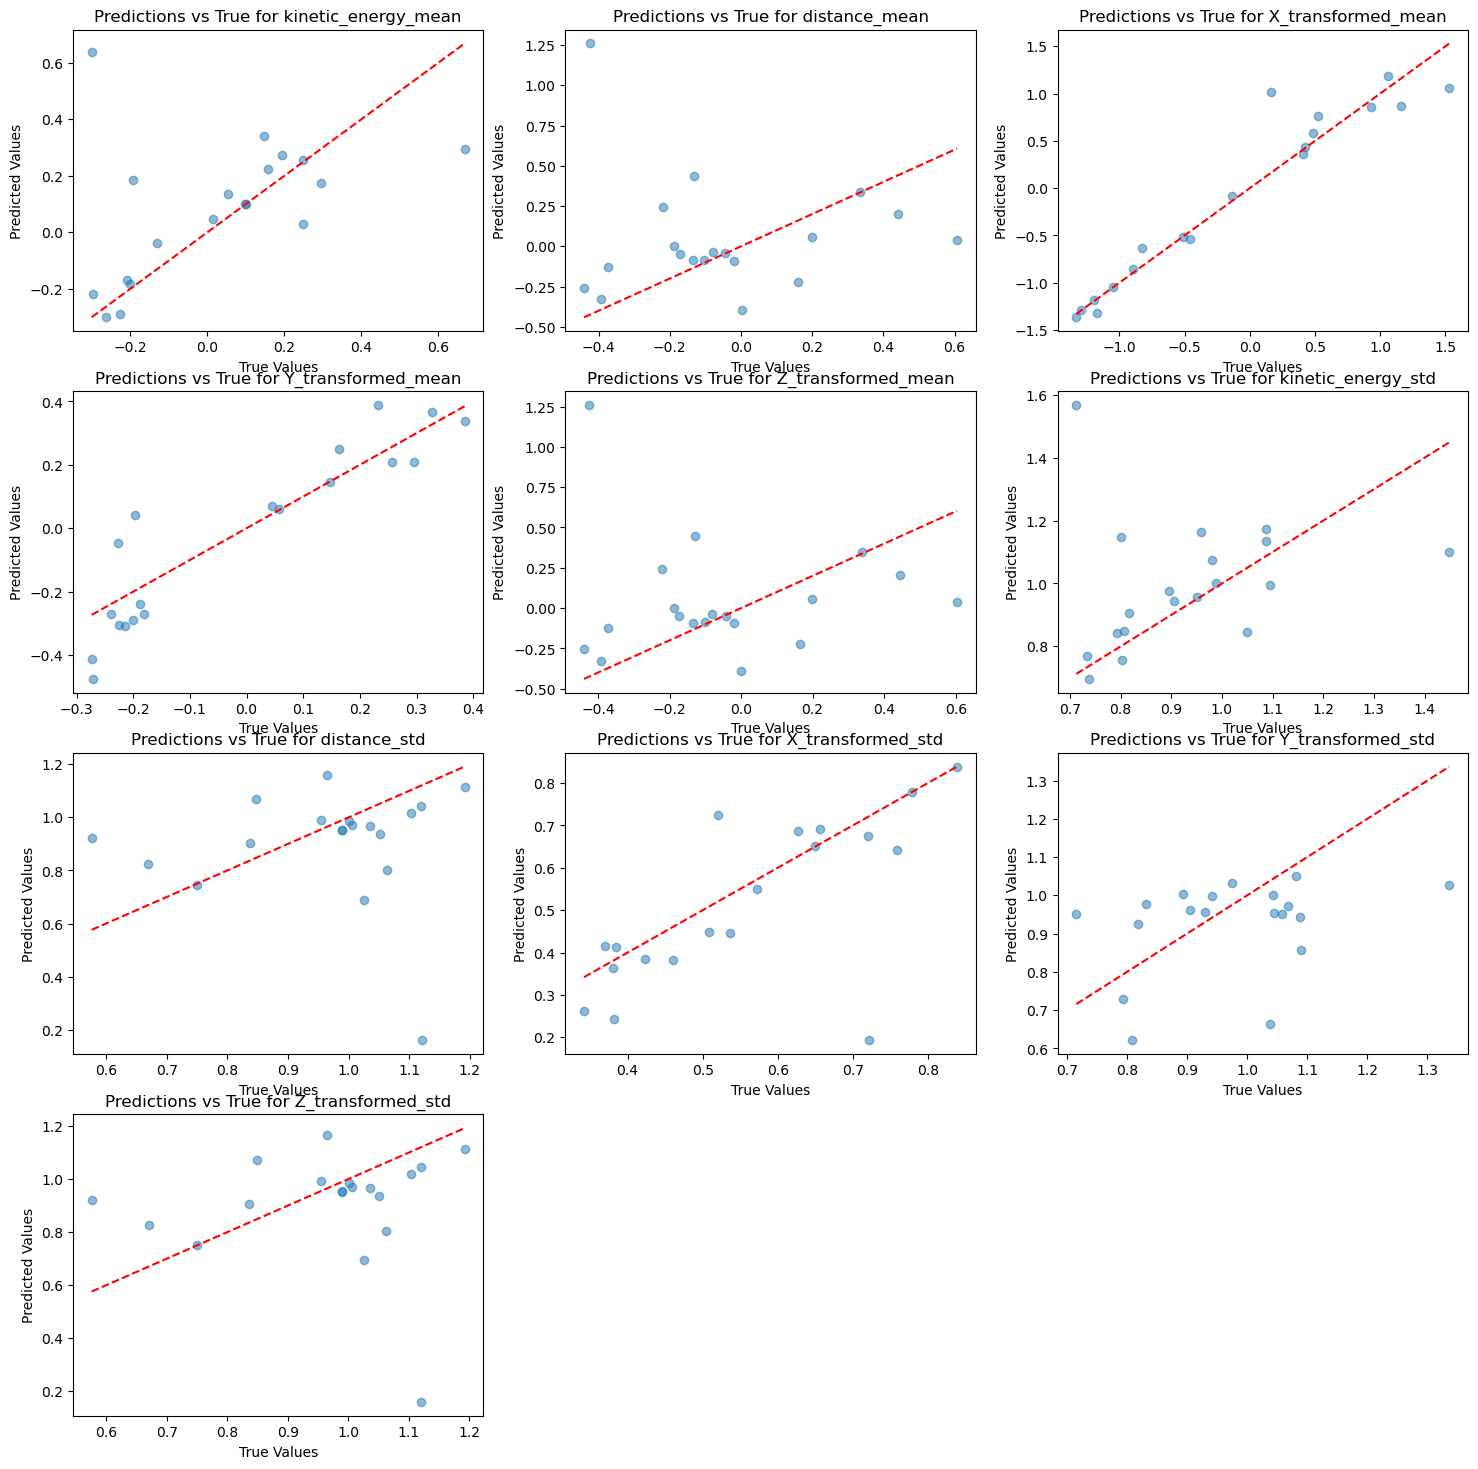

In [85]:
# plot targets vs predictions for validation set
import numpy as np
val_outputs_np = val_outputs.detach().numpy()
val_targets_np = val_targets.detach().numpy()  
plt.figure(figsize=(18, 18))
# use 3 columns per row
for i, col in enumerate(output_columns):
    plt.subplot(len(output_columns)//3+1, 3, i+1)
    plt.scatter(val_targets_np[:, i], val_outputs_np[:, i], alpha=0.5)
    plt.plot([val_targets_np[:, i].min(), val_targets_np[:, i].max()],
             [val_targets_np[:, i].min(), val_targets_np[:, i].max()], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predictions vs True for {col}")
